In [1]:
!pip install deepctr_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 490.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77038 sha256=1fd60b184dd1f2ed5f2bcde2334237237d91f543d047200b6cc64451c03e10cd
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
 

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc 

import torch
from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

plt.style.use('ggplot')

import warnings as w
w.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)

In [3]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))


if __name__ == "__main__":
    data = pd.read_csv("../input/example-movie/movielens_sample.txt")
    sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]
    target = ['rating']

    # 1.Label Encoding for sparse features,and process sequence features
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    # preprocess the sequence feature

    key2index = {}
    genres_list = list(map(split, data['genres'].values))
    genres_length = np.array(list(map(len, genres_list)))
    max_len = max(genres_length)
    # Notice : padding=`post`
    genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )

    # 2.count #unique features for each sparse field and generate feature config for sequence feature

    fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4)
                              for feat in sparse_features]

    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean')]  # Notice : value 0 is for padding for sequence input feature

    linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
    dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

    feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model
    model_input = {name: data[name] for name in sparse_features}  #
    model_input["genres"] = genres_list

    # 4.Define Model,compile and train

    device = 'cpu'
    use_cuda = True
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

    model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

    model.compile("adam", "mse", metrics=['mse'], )
    history = model.fit(model_input, data[target].values, batch_size=256, epochs=50, verbose=2, validation_split=0.2)


cuda ready...
cuda:0
Train on 160 samples, validate on 40 samples, 1 steps per epoch
Epoch 1/50
1s - loss:  14.2732 - mse:  14.2732 - val_mse:  13.1859
Epoch 2/50
0s - loss:  13.9569 - mse:  13.9569 - val_mse:  12.9351
Epoch 3/50
0s - loss:  13.6791 - mse:  13.6791 - val_mse:  12.6970
Epoch 4/50
0s - loss:  13.4145 - mse:  13.4145 - val_mse:  12.4673
Epoch 5/50
0s - loss:  13.1584 - mse:  13.1584 - val_mse:  12.2652
Epoch 6/50
0s - loss:  12.9307 - mse:  12.9307 - val_mse:  12.0673
Epoch 7/50
0s - loss:  12.7072 - mse:  12.7072 - val_mse:  11.8618
Epoch 8/50
0s - loss:  12.4756 - mse:  12.4756 - val_mse:  11.6485
Epoch 9/50
0s - loss:  12.2356 - mse:  12.2356 - val_mse:  11.4272
Epoch 10/50
0s - loss:  11.9870 - mse:  11.9870 - val_mse:  11.1975
Epoch 11/50
0s - loss:  11.7292 - mse:  11.7292 - val_mse:  10.9592
Epoch 12/50
0s - loss:  11.4619 - mse:  11.4619 - val_mse:  10.7121
Epoch 13/50
0s - loss:  11.1846 - mse:  11.1846 - val_mse:  10.4558
Epoch 14/50
0s - loss:  10.8971 - mse:  

In [4]:
loss = pd.DataFrame.from_dict(history.history)

In [5]:
loss.head()

,loss,mse,val_mse
0,14.273169,14.273171,13.185902
1,13.956895,13.956896,12.935057
2,13.679080,13.679080,12.696996
3,13.414459,13.414459,12.467323
4,13.158435,13.158435,12.265163


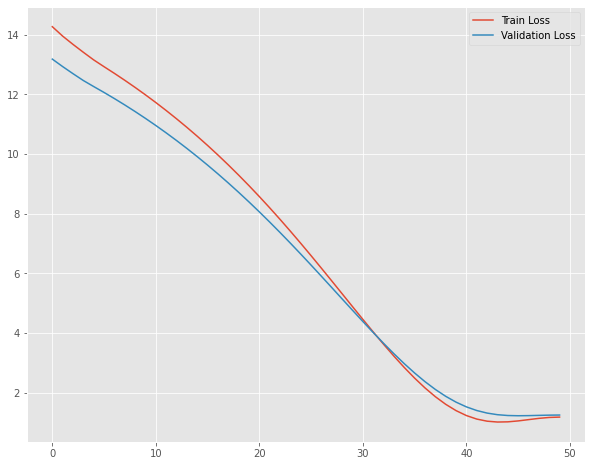

In [6]:
plt.figure(figsize=(10,8))
plt.plot(loss.mse,label='Train Loss')
plt.plot(loss.val_mse,label='Validation Loss')
plt.legend()
plt.show()

### criteo : https://www.kaggle.com/code/leejunseok97/deepfm-criteo-pytorch

In [7]:
# class feat_linear(nn.Module):
#     def __init__(self,field_dim_list,output_dim=1):
#         super().__init__()
#         self.fc = nn.Embedding(sum(field_dim_list),output_dim)
#         self.bias = nn.Parameter(torch.zeros((output_dim,)))
#         self.offsets = np.array((0, *np.cumsum(field_dim_list)[:-1]),dtype=np.long)
#     def forward(self,x):
#         x += x.new_tensor(self.offsets).unsqueeze(0)
#         return torch.sum(self.fc(x),dim=1) + self.bias

In [8]:
# class feat_embedding(nn.Module):
#     def __init__(self,field_dim_list,emb_dim=16):
#         super().__init__()
#         self.embedding = nn.Embedding(sum(field_dim_list),emb_dim)
#         self.offsets = np.array((0, *np.cumsum(field_dim_list)[:-1]),dtype=np.long)
#         nn.init.xavier_uniform_(self.embedding.weight.data)
#     def forward(self,x):
#         x += x.new_tensor(self.offsets).unsqueeze(0)

In [9]:
# class FM(nn.Module):
#     def __init__(self,reduce_sum=True):
#         super().__init__()
#         self.reduce_sum = reduce_sum
#     def forward(self,x):
#         square_sum = torch.sum(x,dim=1) ** 2
#         sum_square = torch.sum(x ** 2,dim=1)
#         ix = square_sum - sum_square
#         if self.reduce_sum:
#             ix = torch.sum(ix,dim=1,keepdim=True)
#         return 0.5 * ix

In [10]:
# class FactoizationMachineModel(nn.Module):
#     def __init__(self,field_dims,embed_dim):
#         super().__init__()
#         self.embedding = feat_embedding(field_dims,embed_dim)
#         self.linear = feat_linear(field_dims)
#         self.fm = FM(reduce_sum=True)
#     def forward(self,x):
#         x = self.linear(x) + self.fm(self.embedding(x))
#         return torch.sigmoid(x.squeeze(1))

In [11]:
# model = FactoizationMachineModel(field_dims=dataset.field_dims,embed_dim=16)
# model

In [12]:
# from tqdm import tqdm
# optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)
# criterion = torch.nn.BCEWithLogitsLoss()
# epochs = 100
# device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# train_acc =  torch.zeros(epochs)
# valid_acc =  torch.zeros(epochs)
# train_loss = torch.zeros(epochs)
# valid_loss = torch.zeros(epochs)
# model.to(device)
# for e in range(epochs):
#     model.train()
#     for data,label in tqdm(train_loader):
#         data,label = data.to(device),label.to(device)
        
#         optimizer.zero_grad()
#         logits = model(data)
#         loss = criterion(logits,label)
#         loss.backward()
#         optimize.step()
        
#         train_loss[e] += loss.item()
        
#         softmax = logits.softmax(1)
#         argmax = softmax.argmax(1)
#         equals = argmax == labels.reshape(argmax.shape)
        
#         train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
        
#     train_acc[e] /= len(train_loader)
#     train_loss[e] /= len(valid_loader)
    
#     print('Epoch:{}/{} Train Accuracy:{:.3f}\tTrain Loss:{:.3f}'.format(e,epochs,train_acc[e],train_loss[e]))

In [14]:
data

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,107,12,4,968035345,Ed Wood (1994),Comedy|Drama,0,2,4,35
1,123,169,3,966536874,Patriot Games (1992),Action|Thriller,1,1,4,118
2,12,6,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,0,2,13,99
3,21,112,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,1,1,18,55
4,187,45,5,957782527,"Apartment, The (1960)",Comedy|Drama,1,5,19,41
...,...,...,...,...,...,...,...,...,...,...
195,46,176,3,974840560,Screwed (2000),Comedy,1,2,11,48
196,131,89,3,965855033,Fire Down Below (1997),Action|Drama|Thriller,1,1,11,113
197,4,125,3,976730191,Desperately Seeking Susan (1985),Comedy|Romance,0,1,13,83
198,181,15,4,958503395,Clear and Present Danger (1994),Action|Adventure|Thriller,1,2,0,106
